In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import glob
from ase.units import Bohr

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
from bt_tools import BDE_dist
from bt_tools import get_distances
import utils_qm as uqm

In [2]:
def morse(var, alpha, beta, b_prime, De, re, a):
    Z1, Z2, d = var.T
    comp = (-beta*(Z1**(7/3)+Z2**(7/3))+alpha+b_prime*Z1*Z2)
    dist = De*(1-np.exp(-a*(d-re)))*(1-np.exp(-a*(d-re)))-Z1*Z2/d
    return(comp*dist)

def comp_dist2(var, alpha, beta, b_prime, a, b):
    Z1, Z2, d = var.T
    comp = (-beta*(Z1**(7/3)+Z2**(7/3))+alpha+b_prime*Z1*Z2)
    dist = a/d+b#+b/d+c
    return(comp*dist)

def dist_key(x):
    pattern_list = ['d1.42', 'd1.75', 'd2.0', 'd2.12', 'd2.25', 'd2.36']
    for i, p in enumerate(pattern_list):
        if p in x:
            return(i)

# # def ebfe_fit_gamma(Zs, beta, alpha, gamma, b_prime):
def ebfe_fit_gamma(Zs, beta, gamma, b_prime):
    Z1, Z2 = Zs.T
    return(-beta/2*(np.power(Z1, gamma)+np.power(Z2, gamma))+2*b_prime*Z1*Z2)

def get_r2(predicted, ref):
    return(1 - ((predicted-ref)**2).sum()/((ref-ref.mean())**2).sum())

### show data

In [3]:
row = 'row_3'

if row == 'row_2':
    istart = 0
    iend = 10
    nuc_charges = [[6, 7, 8, 9]]
elif row == 'row_3':
    istart = 10
    iend = 20 
    nuc_charges = [[14, 15, 16, 17]]
elif row == 'row_4':
    istart = 20
    iend = 30 
    nuc_charges = [[32, 33, 34, 35]]
    
energies = []
for p in ['d1.42', 'd1.75', 'd2.0', 'd2.12', 'd2.25', 'd2.36']:
    energies.append(np.loadtxt(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/distance/energies_{p}.txt')[istart:iend])
    
energies = np.concatenate(tuple(energies), axis = 0)
distances = (np.array([1.42, 1.75, 2.0, 2.12, 2.25, 2.36])/Bohr)
b = BDE_dist(energies, nuc_charges, distances)


# z = (b.xdata[:,0]*b.xdata[:,1])[:10]
plt.rcParams['font.size'] = 20
for i in range(10):
    plt.plot(b.distances, b.ebfe[i + np.array([0, 10, 20, 30, 40, 50])], '-o', label = f'{int(b.xdata[i][0])}, {int(b.xdata[i][1])}')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('$d$ (Ang)')
plt.ylabel(r'$E_{\rm{EBFE}}$ (kcal/mol)')

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

Text(0, 0.5, '$E_{\\rm{EBFE}}$ (kcal/mol)')

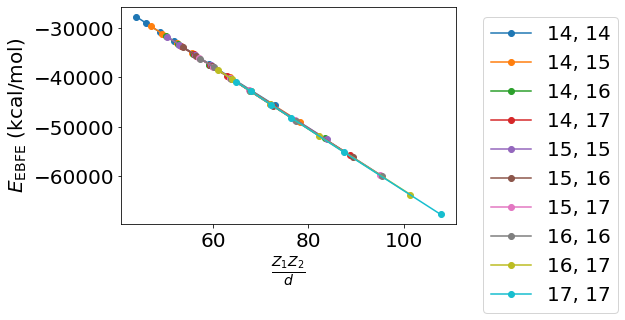

In [60]:
plt.rcParams['font.size'] = 20
for i in range(10):
    plt.plot(b.xdata[i][0]*b.xdata[i][1]/b.distances, b.ebfe[i + np.array([0, 10, 20, 30, 40, 50])], '-o', label = f'{int(b.xdata[i][0])}, {int(b.xdata[i][1])}')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel(r'$\frac{Z_1 Z_2}{d}$')
plt.ylabel(r'$E_{\rm{EBFE}}$ (kcal/mol)')

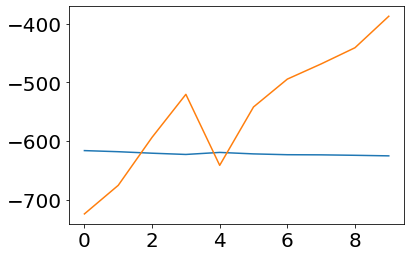

In [61]:
from scipy.stats import linregress
slope = []
intercept = []
for i in range(10):
    out_lin = linregress((b.xdata[i][0]*b.xdata[i][1]/b.distances), b.ebfe[i + np.array([0, 10, 20, 30, 40, 50])])
    slope.append(out_lin[0])
    intercept.append(out_lin[1])
    
plt.plot(slope)
plt.plot(intercept)

### fit Morse

In [62]:
b.fit(morse)
b.params

/home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([ 6.19070101e+02, -3.40949585e-02, -1.59439414e-01, -8.74651409e-01,
        -2.80843870e+02,  5.47985219e+02]),
 array([[inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf]]))

Text(0.5, 0, 'BDE${_{\\rm{pred}}}$ (kcal/mol)')

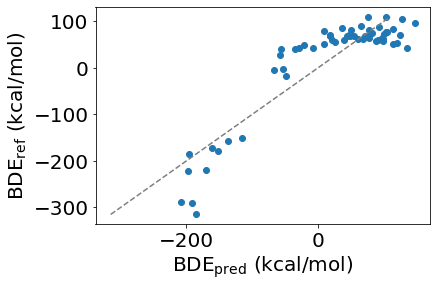

In [63]:
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [6,4]
plt.plot(b.bde_fitted, b.bde, 'o')

bref = np.linspace(np.amin(b.bde), np.amax(b.bde), 5)
plt.plot(bref, bref, '--', color = 'tab:grey')
plt.ylabel(r'BDE${_{\rm{ref}}}$ (kcal/mol)')
plt.xlabel(r'BDE${_{\rm{pred}}}$ (kcal/mol)')

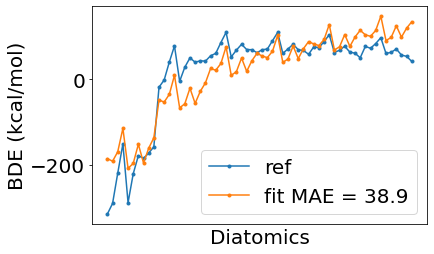

In [64]:
# plt.plot(b.bde, '-o', markersize = 3)
plt.plot(b.bde, '-o', label = 'ref', markersize = 3)
plt.plot(b.bde_fitted, '-o', label = f'fit MAE = {np.round(b.mae, 1)}',markersize = 3)
plt.xticks([])
plt.xlabel('Diatomics')
plt.ylabel('BDE (kcal/mol)')
plt.legend()

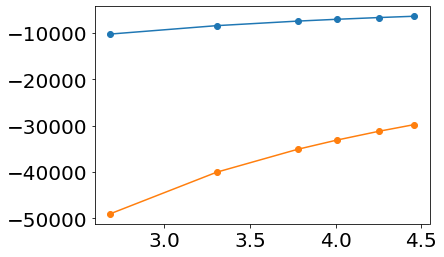

In [65]:
alpha = b.params[0][0]
beta = b.params[0][1]
b_prime = b.params[0][2]
De = b.params[0][3]
re = b.params[0][4]
a = b.params[0][5]
Z1 = 6
Z2 = 7

E_Z = (-beta*(Z1**(7/3)+Z2**(7/3))+alpha+b_prime*Z1*Z2)

d = distances
plt.plot(d, E_Z*(De*(1-np.exp(-a*(d-re)))*(1-np.exp(-a*(d-re)))-Z1*Z2/d), '-o')
i = 1
plt.plot(b.distances, b.ebfe[i + np.array([0, 10, 20, 30, 40, 50])], '-o', label = f'{int(b.xdata[i][0])}, {int(b.xdata[i][1])}')

In [66]:
np.exp(-a*(d-re))

array([0., 0., 0., 0., 0., 0.])

### fit to $\frac{a}{d} + b$

In [67]:
b.fit(comp_dist2)

Text(0.5, 0, 'BDE${_{\\rm{pred}}}$ (kcal/mol)')

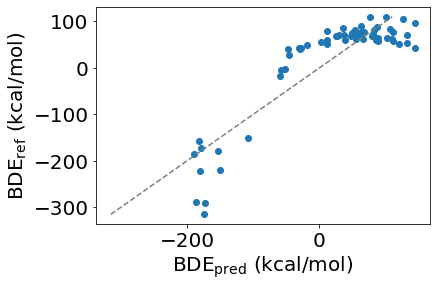

In [68]:
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [6,4]
plt.plot(b.bde_fitted, b.bde, 'o')

bref = np.linspace(np.amin(b.bde), np.amax(b.bde), 5)
plt.plot(bref, bref, '--', color = 'tab:grey')
plt.ylabel(r'BDE${_{\rm{ref}}}$ (kcal/mol)')
plt.xlabel(r'BDE${_{\rm{pred}}}$ (kcal/mol)')

In [69]:
b.mae

41.715043528791355

In [70]:
b.params[0]

array([-48.82186705,   0.35583561, -29.34229511,  19.8583584 ,
         0.07046294])

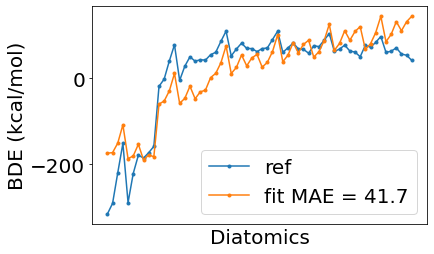

In [71]:
# plt.plot(b.bde, '-o', markersize = 3)
plt.plot(b.bde, '-o', label = 'ref', markersize = 3)
plt.plot(b.bde_fitted, '-o', label = f'fit MAE = {np.round(b.mae, 1)}',markersize = 3)
plt.xticks([])
plt.xlabel('Diatomics')
plt.ylabel('BDE (kcal/mol)')
plt.legend()

In [72]:
b.mae

41.715043528791355

### all rows together

In [ ]:
for e, z, d in zip([e2, e3, e4], z_eff, distances):
    e_nuc = []
    for i in range(len(z)):
        for j in range(i, len(z)):
            e_nuc.append(z[i]*z[j])
    e_nuc = np.array(e_nuc)
    e_el = (e[:,0] - e_nuc).copy()
    e[:,1] = e_el
    e[:,2] = e_nuc


energies = np.concatenate((e2, e3, e4), axis = 0)

In [77]:
e2 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/energies_single.txt')
e3 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_3/energies_single.txt')
e4 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_4/energies_single.txt')
nuc_charges = [[6, 7, 8, 9], [14, 15, 16, 17], [32, 33, 34, 35]]
distances = np.array([1.42, 2.12, 2.36])/Bohr

for e, z in zip([e2, e3, e4], nuc_charges):
    e_nuc = []
    for i in range(len(z)):
        for j in range(i, len(z)):
            e_nuc.append(z[i]*z[j])
    e_nuc = np.array(e_nuc)
    e_el = (e[:,0] - e_nuc).copy()
    e[:,1] = e_el
    e[:,2] = e_nuc

energies = np.concatenate((e2, e3, e4), axis = 0)

# 
b = BDE_dist(energies, nuc_charges, distances)
xd2 = b.xdata[:10].copy()
xd3 = b.xdata[40:50].copy()
xd4 = b.xdata[80:].copy()
b.xdata = xdata = np.concatenate((xd2, xd3, xd4), axis = 0)

In [78]:
b.fit(comp_dist2)
b.mae

9.481632493149949

In [1]:
el1 = ['C', 'N', 'O', 'F']
el2 = ['Si', 'P', 'S', 'Cl']
el3 = ['Ge', 'As', 'Se', 'Br']
comps = []
for el in [el1, el2, el3]:
    for i in range(len(el)):
        for j in range(i, len(el)):
            comps.append(f'{el[i]}{el[j]}')

plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(comps, b.bde, '-o', label = 'ref')
plt.plot(b.bde_fitted, '-o', label = f'pred MAE = {np.round(b.mae,1)}')
plt.ylabel('BDE (kcal/mol)')
plt.legend()

NameError: name 'plt' is not defined

In [2]:
comps

['CC',
 'CN',
 'CO',
 'CF',
 'NN',
 'NO',
 'NF',
 'OO',
 'OF',
 'FF',
 'SiSi',
 'SiP',
 'SiS',
 'SiCl',
 'PP',
 'PS',
 'PCl',
 'SS',
 'SCl',
 'ClCl',
 'GeGe',
 'GeAs',
 'GeSe',
 'GeBr',
 'AsAs',
 'AsSe',
 'AsBr',
 'SeSe',
 'SeBr',
 'BrBr']

Text(0.5, 0, 'BDE${_{\\rm{pred}}}$ (kcal/mol)')

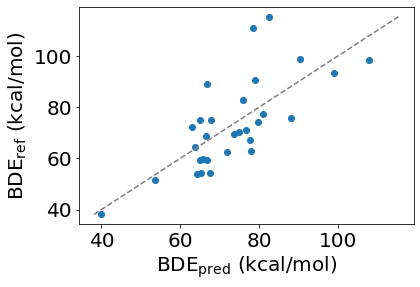

In [76]:
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [6,4]
plt.plot(b.bde_fitted, b.bde, 'o')

bref = np.linspace(np.amin(b.bde), np.amax(b.bde), 5)
plt.plot(bref, bref, '--', color = 'tab:grey')
plt.ylabel(r'BDE${_{\rm{ref}}}$ (kcal/mol)')
plt.xlabel(r'BDE${_{\rm{pred}}}$ (kcal/mol)')
# plt.legend()

In [21]:
np.abs(b.bde-b.bde_fitted).mean()

9.56752210685017

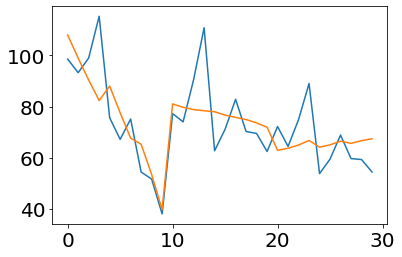

In [22]:
b.fit(comp_dist2)
plt.plot(b.bde)
plt.plot(b.bde_fitted)

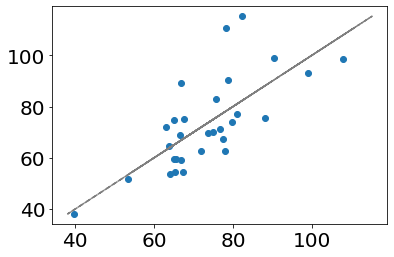

In [23]:
plt.plot(b.bde_fitted, b.bde, 'o')
plt.plot(b.bde, b.bde, '--', color = 'tab:grey')